In [1]:
""" Finding Trends of Stock Prices """
import pandas as pd 
import numpy as np 
import sqlite3 as sql 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm 

import sys
sys.path.append('/Users/jerald/Documents/Dir/Python/Stocks')
from bin.main import Manager, get_path 

connections = get_path('../../../../../')
J = Manager(connections)

2025-02-28 22:15:36,326 - INFO - Options DB Initialized
2025-02-28 22:15:36,327 - WARNING - You currently have 8 connections open.
2025-02-28 22:15:36,328 - INFO - Option Chain Module Initialized
2025-02-28 22:15:36,330 - INFO - PriceDB Initialized successfully at 2025-02-28 22:15:36.330728
2025-02-28 22:15:36,330 - INFO - PriceDB Initialized successfully at 2025-02-28 22:15:36.330728
2025-02-28 22:15:36,331 - INFO - Established 3 database connections
2025-02-28 22:15:36,331 - INFO - Established 3 database connections
2025-02-28 22:15:36,447 - INFO - Notifications instance initialized.


In [77]:
import statsmodels.api as sm 

def trend_model(stock, conn, ci_level = 0.01, N = 200):
    try:
        #### Get the Close prices from the connector 
        # prices = conn.Pricedb.ohlc(stock, daily = False, start = '2025-02-01')['Close'].to_frame()
        prices = conn.Pricedb.ohlc(stock, daily = True, start = "2024-10-01")['Close'].to_frame()
        
        ### Fit the model using the 1 day return
        df = prices.pct_change().dropna()
        
        #### Format the dates, use: Period date index 
        df.index = pd.to_datetime(df.index).to_period('D')
        df_last_date = df.index[-1].to_timestamp()
        forecast_date = df.index[-1] + pd.Timedelta(days = 1)
        forecast_date = forecast_date.to_timestamp()
        
        #### Apply SARIMAX model: 
        smax = sm.tsa.statespace.SARIMAX(df, trend = 'ct', order = (1,0,5)).fit(disp = False, method = 'powell')
        
        # Predictions & CI from the last date of the data 
        pred_dy = smax.get_prediction(dynamic = df_last_date)
        pred_dy_ci = pred_dy.conf_int(alpha = ci_level)
        
        ## Fitted Predictions
        fitted_predictions = pred_dy.predicted_mean
        lowerpred, upperpred = pred_dy_ci.iloc[0]

        reconstructed = np.array([prices.iloc[0,0] * (1 + fitted_predictions.iloc[0])])
        reconstructed_lower = np.array([prices.iloc[0,0] * (1 + lowerpred)])
        reconstructed_upper = np.array([prices.iloc[0,0] * (1 + upperpred)])

        for i in range(1, len(fitted_predictions)):
            predicted_price = reconstructed[-1] * (1 + fitted_predictions.iloc[i])
            # To find the upper and lower bounds, use the predicted price ± (predicted price * predicted confidence interval)
            upper_predicted_price = reconstructed[-1] + (reconstructed[-1] * pred_dy_ci.iloc[i, 1])
            lower_predicted_price = reconstructed[-1] + (reconstructed[-1] * pred_dy_ci.iloc[i, 0])

            reconstructed = np.append(reconstructed, predicted_price)
            reconstructed_lower = np.append(reconstructed_lower, lower_predicted_price)
            reconstructed_upper = np.append(reconstructed_upper, upper_predicted_price)

            
        out = prices.iloc[1:].rename(columns = {stock[0]: 'Close'})
        out['prediction']= reconstructed
        out['lower'] = reconstructed_lower
        out['upper'] = reconstructed_upper
        return out.round(3)
    except Exception as e:
        print('stock:', stock, e)
        pass

In [78]:
lodf = {j:trend_model(j, J, ci_level = 0.05, N = 100) for j in tqdm(J.Optionsdb.stocks['all_stocks'])}

 79%|███████▊  | 144/183 [00:25<00:05,  7.24it/s]

stock: sony attempt to get argmax of an empty sequence


100%|██████████| 183/183 [00:32<00:00,  5.66it/s]


In [79]:
lodf = {j:lodf[j] for j in lodf if lodf[j] is not None}

In [80]:
def plot_trend(d, fig, ax):
    ax.plot(d.index, d['Close'], label = 'Close', color = 'blue')
    ax.plot(d.index, d['Close'].ewm(alpha = 1/10).mean(), label = 'Close', color = 'gold')
    ax.plot(d.index, d['Close'].ewm(alpha = 1/20).mean(), label = 'Close', color = 'teal')
    ax.plot(d.index, d['prediction'], label = 'Prediction', color = 'red')
    ax.fill_between(d.index, d['lower'], d['upper'], color = 'grey', alpha = 0.2)
    ax.plot()
    fig.autofmt_xdate()

In [81]:
def find_flips(d, n1 = 10, n2 = 20):
    try:
        d = d.copy()
        d['ewm1'] = d['Close'].ewm(alpha = 1/n1).mean()
        d['ewm2'] = d['Close'].ewm(alpha = 1/n2).mean()
        d['ediff'] = d['ewm1'] - d['ewm2']
        return d.ediff.iloc[-1]
    except:
        return None


lastpred = {k: find_flips(v) for k, v in lodf.items() if find_flips(v) is not None}

top = sorted(lastpred, key = lambda x: abs(lastpred[x]), reverse = False)[:10]
print(top)

['uup', 'tost', 'lcid', 'ardx', 'vuzi', 'pfe', 'weat', 'open', 'bno', 'asan']


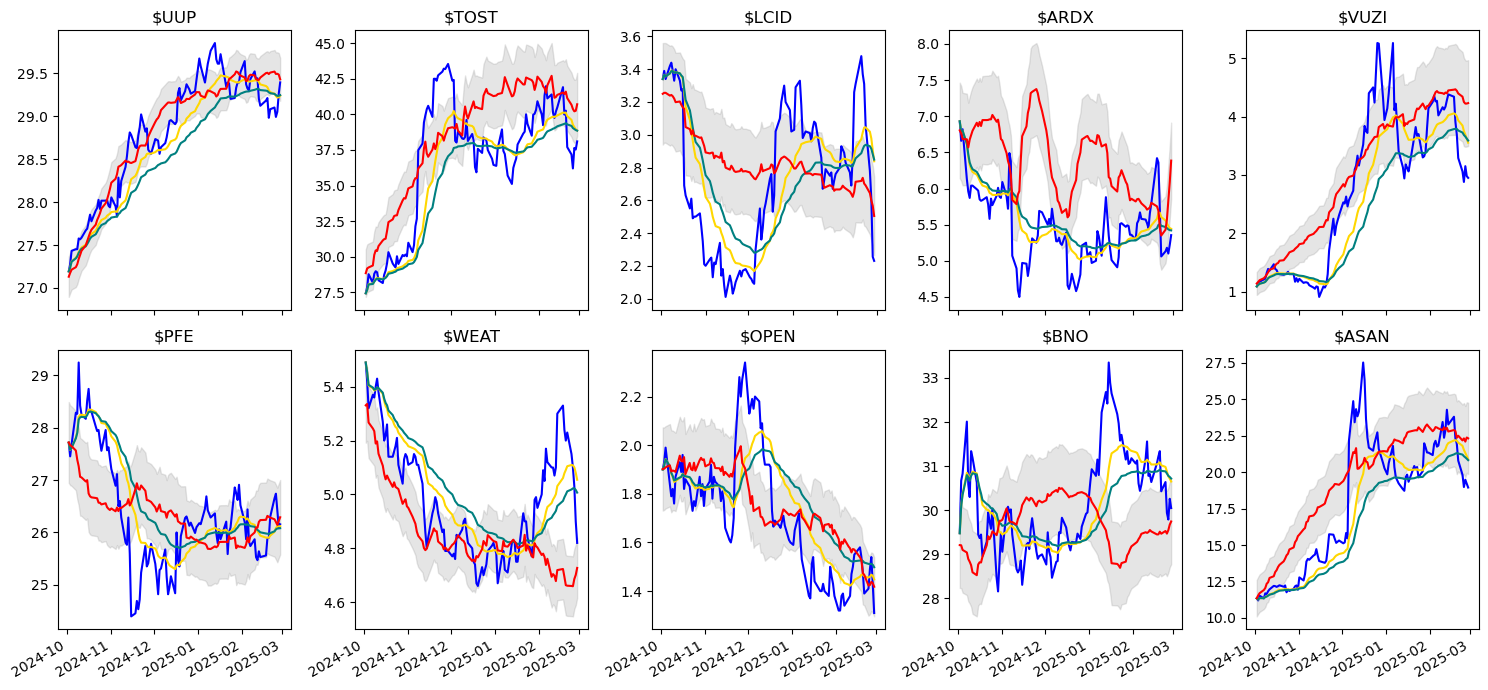

In [82]:
### Stocks that are close to having the faster EMA cross the Slower EMA 

fig, ax = plt.subplots(2, 5, figsize = (15, 7))
ax = ax.flatten()
for i, j in enumerate(top):
    plot_trend(lodf[j], fig, ax[i])
    ax[i].set_title("$"+j.upper())
plt.tight_layout()
plt.show()

In [83]:
# Find all the stocks with the last close the closest to the prediction 
lastpred = {k:v.iloc[-1]['Close']-v.iloc[-1]['prediction'] for k, v in lodf.items()}

# Find the top 5 stocks with the closest prediction
top5 = sorted(lastpred, key = lambda x: abs(lastpred[x]), reverse = False)[:10]
print(top5)

['bil', 'sol', 'uup', 'ebay', 'mrk', 'weat', 'open', 'oxy', 'gsl', 'corn']


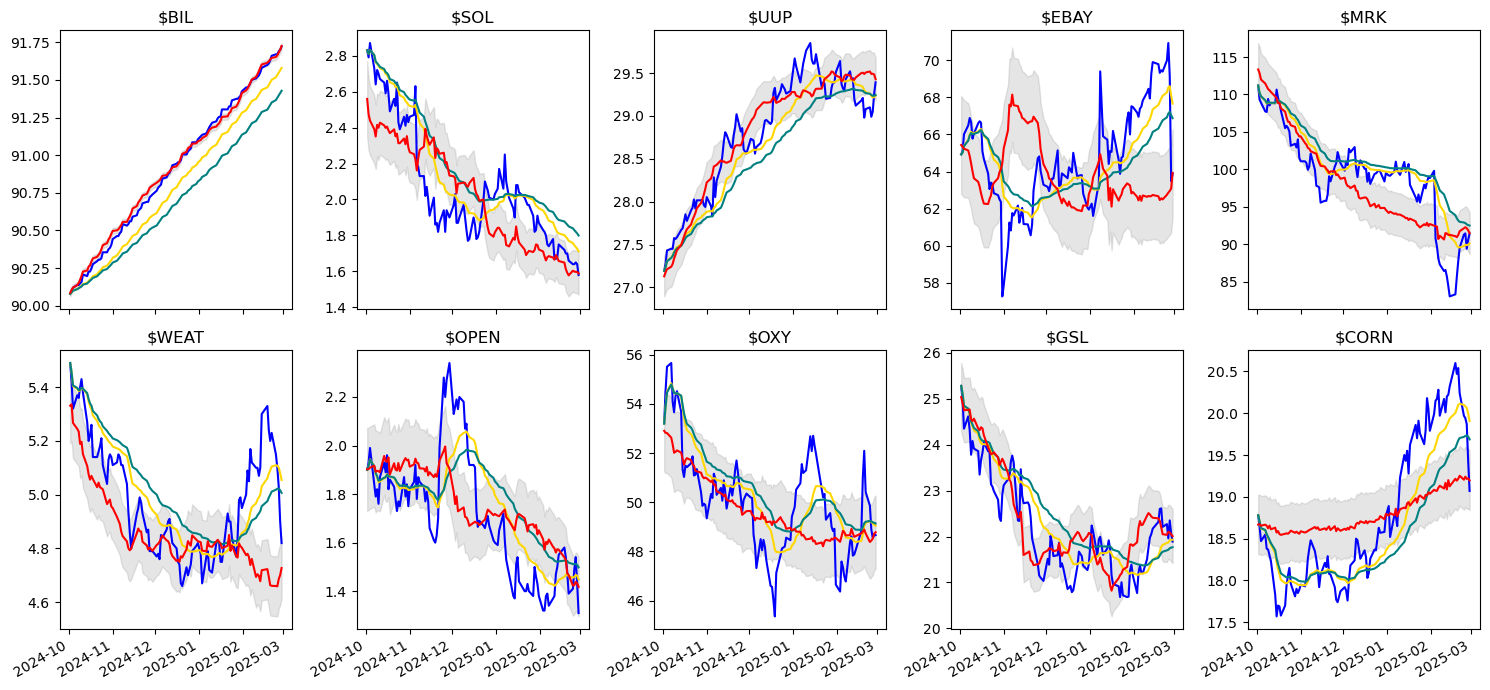

In [84]:
# Stocks that are close to the predicted closing price. (This means that a change in the trend can occur soon)

fig, ax = plt.subplots(2, 5, figsize = (15, 7))
ax = ax.flatten()
for i, j in enumerate(top5):
    plot_trend(lodf[j], fig, ax[i])
    ax[i].set_title("$"+j.upper())
plt.tight_layout()
plt.show()

In [38]:
# l = [('amzn', '2024-08-01'), ('aapl', '2024-08-01'), ('pfe', '2024-07-30'), ('aal', '2024-07-25'), ('uber', '2024-07-30'), ('goog', '2024-07-23'), ('mmm', '2024-07-26'), ('ntr', '2024-07-31'), ('dkng', '2024-08-01'), ('ups', '2024-07-23'), ('sq', '2024-08-01'), ('vale', '2024-07-25'), ('mo', '2024-07-31'), ('intc', '2024-08-01'), ('rrc', '2024-07-23'), ('enph', '2024-07-23'), ('lc', '2024-07-30'), ('lmt', '2024-07-23'), ('mrk', '2024-07-30'), ('qcom', '2024-07-31'), ('ardx', '2024-07-31'), ('mos', '2024-07-30'), ('qs', '2024-07-24'), ('msft', '2024-07-23'), ('meta', '2024-07-31'), ('abbv', '2024-07-25'), ('rkt', '2024-08-01'), ('nflx', '2024-07-18'), ('ccj', '2024-07-31'), ('ebay', '2024-07-24'), ('f', '2024-07-24'), ('pypl', '2024-07-31'), ('ibm', '2024-07-24'), ('amd', '2024-07-30'), ('coin', '2024-08-01'), ('sbux', '2024-07-30'), ('rtx', '2024-07-25'), ('ba', '2024-07-31'), ('cmre', '2024-07-26'), ('ge', '2024-07-23'), ('snap', '2024-08-01'), ('ctva', '2024-07-31'), ('ko', '2024-07-23'), ('ctra', '2024-08-01'), ('roku', '2024-07-25'), ('spwr', '2024-07-30'), ('abnb', '2024-08-01'), ('v', '2024-07-23'), ('x', '2024-08-01'), ('eog', '2024-08-01'), ('clx', '2024-08-01'), ('k', '2024-08-01'), ('spot', '2024-07-23'), ('pgr', '2024-08-01'), ('afl', '2024-07-31'), ('aig', '2024-07-31'), ('sofi', '2024-07-29'), ('dash', '2024-07-31'), ('open', '2024-08-01'), ('dbx', '2024-08-01'), ('tdoc', '2024-07-23')]
# earn = [i[0] for i in l][:20]

#### Now we need to do this over different time frames 
# earn = ['aal', 'goog', 'mmm', 'ups', 'vale', 'rrc', 'enph', 'lmt', 'qs', 'msft', 'abbv', 'nflx', 'ebay', 'f', 'ibm', 'rtx', 'cmre', 'ge', 'aa', 'ko', 'roku', 'spwr', 'v', 'spot', 'ual', 'pgr', 'tdoc', 'djt', 'mo', 'pfe']
# Create an evenly spaced grid given the list
 
ncols = 5
# nrows = int(len(earn) / ncols) 

# fig, ax = plt.subplots(nrows,ncols, figsize = (15, 15))
# ax = ax.flatten()
# for i, j in enumerate(earn):
#     plot_trend(lodf[j], fig, ax[i])
#     ax[i].set_title("$"+j.upper())
# plt.tight_layout()
# plt.show()